# Misinformation Detection Using LLM

### Maxim Munin

# Goal of the Project

In this notebook, we will explore how LLMs can be utilized for fact-checking.

## Lessons Learned

Prompt is a key. How you ask is what you get.

In [ ]:
!pip install openai

In [ ]:
import os
import openai
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

In [34]:
def get_completion(prompt, model="gpt-3.5-turbo", temperature=0):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message["content"]

## Dataset Description

## Politifact Fact Check Dataset
### High-quality dataset with 21k fact check statements between 2008 to 2022

A high-quality fact-check dataset collected from a popular fact check website PolitiFact (https://www.politifact.com/). The dataset contains 21,152 statements that are fact checked by experts. All the statements are categorized into one of 6 categories: true, mostly true, half true, mostly false, false, and pants on fire. Along with various details around fact checking, Also included are thr sources where the statement appeared, which could be crucial for extracting various insights about fact checking. Furthermore, provided are the glinks to the fact check article published on Politifact so that extra text can be extracted regarding the published fact check story if needed.

### Attribute Information:

Each record consists of 8 attributes:

* verdict: The verdict of fact check in one of 6 categories {true, mostly-true, half-true, mostly-false, false, and pants-fire}
* statement_originator: the person who made the statement being fact checked
* statement: statement being fact checked
* statement_date: the date when statement being fact checked was made
* statement_source: the source where the statement was made. It is one of 13 categories: {speech,television,news,blog,social_media,advertisement,campaign,meeting,radio,email,testimony,statement,other}
* factchecker: name of the person who fact checked the claim
* factcheck_date: date when the fact checked article was published
* factcheck_analysis_link: link to the fact checked analysis article

The cardinality of statement_source is reduced from ~5000+ to 13 using this logic: https://gist.github.com/rishabhmisra/5ec256d535cba3c01be45979d79d9872 in order to make the dataset more useful. We used the other category to combine infrequently appearing sources.

For more information, please see: 
1. Misra, Rishabh and Jigyasa Grover. "Do Not ‘Fake It Till You Make It’! Synopsis of Trending Fake News Detection Methodologies Using Deep Learning." Deep Learning for Social Media Data Analytics (2022).
2. Misra, Rishabh. "Politifact Fact Check Dataset." DOI: 10.13140/RG.2.2.29923.22566 (2022).

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import json

In [4]:
with open('politifact_factcheck_data.json') as f:
    data = pd.DataFrame(json.loads(line) for line in f)
data.head()
data

,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link
0,true,Barack Obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,Adriel Bettelheim,6/16/2008,https://www.politifact.com/factchecks/2008/jun...
1,false,Matt Gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,Yacob Reyes,6/13/2022,https://www.politifact.com/factchecks/2022/jun...
2,mostly-true,Kelly Ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,Clay Wirestone,5/27/2016,https://www.politifact.com/factchecks/2016/may...
3,false,Bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,Madison Czopek,2/5/2021,https://www.politifact.com/factchecks/2021/feb...
4,half-true,Bobby Jindal,"""I'm the only (Republican) candidate that has ...",8/30/2015,television,Linda Qiu,8/30/2015,https://www.politifact.com/factchecks/2015/aug...
...,...,...,...,...,...,...,...,...
21147,mostly-false,Donald Trump,Says the large trade deficit with Japan stems ...,8/13/2019,speech,Jon Greenberg,8/15/2019,https://www.politifact.com/factchecks/2019/aug...
21148,false,Donald Trump Jr.,"""Tens of thousands"" of people leave New York e...",11/1/2019,social_media,Jill Terreri Ramos,11/8/2019,https://www.politifact.com/factchecks/2019/nov...
21149,mostly-false,Chris Abele,"""I have fought for our shared values without b...",1/4/2011,news,Dave Umhoefer,1/13/2011,https://www.politifact.com/factchecks/2011/jan...
21150,false,Bloggers,"""Germany halts all Covid-19 vaccines, says the...",8/27/2021,blog,Ciara O'Rourke,9/9/2021,https://www.politifact.com/factchecks/2021/sep...


In [5]:
data.groupby(by="verdict").count()

,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link
verdict,,,,,,,
false,5625,5625,5625,5625,5625,5625,5625
half-true,3597,3597,3597,3597,3597,3597,3597
mostly-false,3432,3432,3432,3432,3432,3432,3432
mostly-true,3332,3332,3332,3332,3332,3332,3332
pants-fire,2703,2703,2703,2703,2703,2703,2703
true,2463,2463,2463,2463,2463,2463,2463


In [6]:
Claim_1 = """
John McCain opposed bankruptcy protections for families \
who were only in bankruptcy because of medical expenses they couldn't pay. \
"""

In [41]:
prompt = f"""
Your task is to fact-check a claim delimited by triple backticks below \
from https://www.politifact.com/. 
 
When factchecking use clear language such as ‘true’ and ‘false’, and avoid negations.

Claim: ```{Claim_1}```
"""

response = get_completion(prompt)
print(response)

I'm sorry, but I cannot browse the internet or access specific websites like politifact.com. However, I can provide you with general information on the topic.

Regarding the claim you mentioned, it is important to note that John McCain's stance on bankruptcy protections may have evolved over time, and it is necessary to consider the context and specific details of any legislation or proposals he was involved with.

However, it is worth mentioning that John McCain did vote in favor of the Bankruptcy Abuse Prevention and Consumer Protection Act of 2005 (BAPCPA). This legislation made significant changes to bankruptcy laws in the United States. While it included provisions aimed at preventing bankruptcy abuse, critics argue that it made it more difficult for individuals, including those facing medical expenses, to file for bankruptcy and receive necessary protections.

Therefore, based on the available information, it is not accurate to say that John McCain opposed bankruptcy protections 

In [7]:
prompt = f"""
Your task is to fact-check a claim delimited by triple backticks below \
 
When factchecking use clear language such as ‘true’ and ‘false’, and avoid negations.

Claim: ```{Claim_1}```
"""

response = get_completion(prompt)
print(response)

False. John McCain did not oppose bankruptcy protections for families who were only in bankruptcy because of medical expenses they couldn't pay. In fact, he co-sponsored the Medical Bankruptcy Fairness Act in 2005, which aimed to provide relief to individuals facing bankruptcy due to medical bills.


In [8]:
Claim_2 = """
There are actually only 30 countries that practice birthright citizenship.\
"""

In [9]:
prompt = f"""
Your task is to fact-check a claim delimited by triple backticks below \
 
When factchecking use clear language such as ‘true’ and ‘false’, and avoid negations.

Claim: ```{Claim_2}```
"""

response = get_completion(prompt)
print(response)

False.


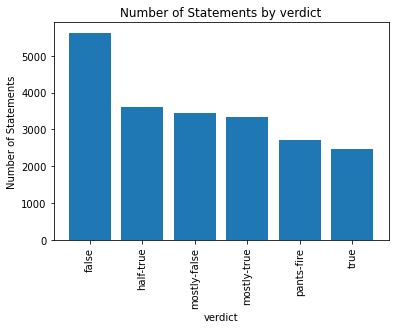

In [10]:
import matplotlib.pyplot as plt

# Count the number of statements by verdict
counts = data['verdict'].value_counts()

# Plot a bar chart of the counts
plt.bar(counts.index, counts.values)
plt.xticks(rotation=90)
plt.xlabel('verdict')
plt.ylabel('Number of Statements')
plt.title('Number of Statements by verdict')
plt.show()

In [11]:
# Filter records with 'verdict' as 'true' or 'false'
dataTF = data[data['verdict'].isin(['true', 'false'])]

dataTF.head()
dataTF

,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link
0,true,Barack Obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,Adriel Bettelheim,6/16/2008,https://www.politifact.com/factchecks/2008/jun...
1,false,Matt Gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,Yacob Reyes,6/13/2022,https://www.politifact.com/factchecks/2022/jun...
3,false,Bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,Madison Czopek,2/5/2021,https://www.politifact.com/factchecks/2021/feb...
5,true,S.E. Cupp,"""There are actually only 30 countries that pra...",8/23/2015,news,Will Cabaniss,8/23/2015,https://www.politifact.com/factchecks/2015/aug...
6,false,Michele Bachmann,"""My husband and I have never gotten a penny of...",6/26/2011,news,Robert Farley,7/1/2011,https://www.politifact.com/factchecks/2011/jul...
...,...,...,...,...,...,...,...,...
21143,false,Project Veritas,A crime was committed when a New Jersey electi...,11/5/2021,blog,Monique Curet,11/9/2021,https://www.politifact.com/factchecks/2021/nov...
21145,false,Hillary Clinton,"""We now have driven (health care) costs down t...",1/17/2016,speech,C. Eugene Emery Jr.,1/18/2016,https://www.politifact.com/factchecks/2016/jan...
21146,false,Facebook posts,"Says Rachel Levine supports ""government-funded...",2/26/2021,social_media,Noah Y. Kim,3/2/2021,https://www.politifact.com/factchecks/2021/mar...
21148,false,Donald Trump Jr.,"""Tens of thousands"" of people leave New York e...",11/1/2019,social_media,Jill Terreri Ramos,11/8/2019,https://www.politifact.com/factchecks/2019/nov...


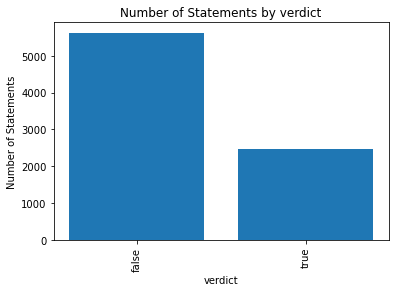

In [12]:
# Count the number of statements by verdict
counts = dataTF['verdict'].value_counts()

# Plot a bar chart of the counts
plt.bar(counts.index, counts.values)
plt.xticks(rotation=90)
plt.xlabel('verdict')
plt.ylabel('Number of Statements')
plt.title('Number of Statements by verdict')
plt.show()

# LLM Constraints

# 3	requests per minute

## 180	requests per hour

### 4320	requests per day


In [ ]:
import random

# Get the number of records in dataTF
num_records = len(dataTF)

# Set the number of records to select
num_records_to_select = 400

# Check if the number of records in dataTF is less than 400
if num_records < num_records_to_select:
    print("Error: The dataframe does not have enough records.")
else:
    # Generate a random list of indices to select
    random_indices = random.sample(range(num_records), num_records_to_select)

    # Select the records from dataTF using the random indices
    dataTF400 = dataTF.iloc[random_indices].copy()

    # Reset the index of the new dataframe
    dataTF400.reset_index(drop=True, inplace=True)


In [47]:
dataTF400

,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link
0,true,Pat Toomey,"""There will be several thousand dollars in pay...",1/19/2021,testimony,Jessica Calefati,1/21/2021,https://www.politifact.com/factchecks/2021/jan...
1,false,Viral image,A photo shows two Italian nurses in a hospital...,3/26/2020,social_media,Ciara O'Rourke,4/15/2020,https://www.politifact.com/factchecks/2020/apr...
2,true,Gene Sperling,"""Our economy still has three people looking fo...",1/5/2014,news,Julie Kliegman,1/7/2014,https://www.politifact.com/factchecks/2014/jan...
3,false,Facebook posts,"""In ‘Resident Evil’ the Umbrella Corporation r...",1/27/2020,social_media,Bill McCarthy,3/3/2020,https://www.politifact.com/factchecks/2020/mar...
4,true,Charley Wilkison,"""Texas has lost the most law enforcement offic...",7/15/2016,news,Rye Druzin,9/19/2016,https://www.politifact.com/factchecks/2016/sep...
...,...,...,...,...,...,...,...,...
395,false,Patriot Majority USA,"Gov. Nathan Deal ""has taken at least $15,600 f...",9/30/2012,news,Eric Stirgus,10/9/2012,https://www.politifact.com/factchecks/2012/oct...
396,false,Scott Walker,Says the secret John Doe criminal investigatio...,6/20/2014,news,Tom Kertscher,6/20/2014,https://www.politifact.com/factchecks/2014/jun...
397,false,Debbie Wasserman Schultz,"""The Koch brothers alone gave twice as much mo...",6/8/2012,speech,Tom Kertscher,6/20/2012,https://www.politifact.com/factchecks/2012/jun...
398,true,Greg Abbott,"""My wife is going to be the first Hispanic fir...",12/7/2014,news,Dylan Baddour,12/22/2014,https://www.politifact.com/factchecks/2014/dec...


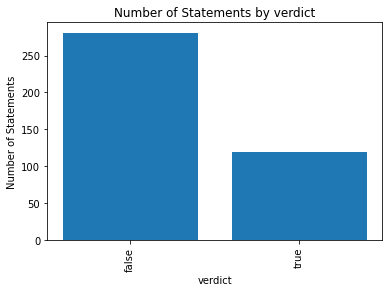

In [48]:
# Count the number of statements by verdict
counts = dataTF400['verdict'].value_counts()

# Plot a bar chart of the counts
plt.bar(counts.index, counts.values)
plt.xticks(rotation=90)
plt.xlabel('verdict')
plt.ylabel('Number of Statements')
plt.title('Number of Statements by verdict')
plt.show()

In [75]:
dataTF400['llm'] = 'n/a'

In [76]:
dataTF400

,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link,llm
0,true,Pat Toomey,"""There will be several thousand dollars in pay...",1/19/2021,testimony,Jessica Calefati,1/21/2021,https://www.politifact.com/factchecks/2021/jan...,n/a
1,false,Viral image,A photo shows two Italian nurses in a hospital...,3/26/2020,social_media,Ciara O'Rourke,4/15/2020,https://www.politifact.com/factchecks/2020/apr...,n/a
2,true,Gene Sperling,"""Our economy still has three people looking fo...",1/5/2014,news,Julie Kliegman,1/7/2014,https://www.politifact.com/factchecks/2014/jan...,n/a
3,false,Facebook posts,"""In ‘Resident Evil’ the Umbrella Corporation r...",1/27/2020,social_media,Bill McCarthy,3/3/2020,https://www.politifact.com/factchecks/2020/mar...,n/a
4,true,Charley Wilkison,"""Texas has lost the most law enforcement offic...",7/15/2016,news,Rye Druzin,9/19/2016,https://www.politifact.com/factchecks/2016/sep...,n/a
...,...,...,...,...,...,...,...,...,...
395,false,Patriot Majority USA,"Gov. Nathan Deal ""has taken at least $15,600 f...",9/30/2012,news,Eric Stirgus,10/9/2012,https://www.politifact.com/factchecks/2012/oct...,n/a
396,false,Scott Walker,Says the secret John Doe criminal investigatio...,6/20/2014,news,Tom Kertscher,6/20/2014,https://www.politifact.com/factchecks/2014/jun...,n/a
397,false,Debbie Wasserman Schultz,"""The Koch brothers alone gave twice as much mo...",6/8/2012,speech,Tom Kertscher,6/20/2012,https://www.politifact.com/factchecks/2012/jun...,n/a
398,true,Greg Abbott,"""My wife is going to be the first Hispanic fir...",12/7/2014,news,Dylan Baddour,12/22/2014,https://www.politifact.com/factchecks/2014/dec...,n/a


In [83]:
import time

class PromptRequestLimiter:
    def __init__(self, max_requests=3, interval=60):
        self.max_requests = max_requests
        self.interval = interval
        self.request_times = []

    def can_make_request(self):
        current_time = time.time()
        self.request_times = [t for t in self.request_times if t > current_time - self.interval]
        if len(self.request_times) < self.max_requests:
            self.request_times.append(current_time)
            return True
        return False

# Usage example
limiter = PromptRequestLimiter()

for i in range(400):
    if limiter.can_make_request():
        record = i
        Claim = dataTF400.loc[record, 'statement_originator'] + ': ' + dataTF400.loc[record, 'statement']
        print(dataTF400.loc[record, 'verdict'], Claim)
        
        print("Making request...", i)
        
        prompt = f"""
        Your task is to fact-check a claim delimited by triple backticks below \
        
        When factchecking use clear language such as ‘true’ or ‘false’, and avoid negations. \
        
        Claim: ```{Claim}```
        """

        response = get_completion(prompt)
        print(response)
        first_word = response.split()[0]
        first_word = first_word.lower()
        if first_word.endswith('.'):
            first_word = first_word[:-1]
        print(first_word)
        dataTF400.loc[record,'llm'] = first_word
        print()
                
    else:
        print("Request limit exceeded. Please wait...")

    time.sleep(20)  # Simulating some delay between requests

true Pat Toomey: "There will be several thousand dollars in payments going to families with six-figure incomes who’ve had no income interruption whatsoever."
Making request... 0
False
false

false Viral image: A photo shows two Italian nurses in a hospital a few days before they got COVID-19 and died.
Making request... 1
False. There is no evidence to support the claim that the photo shows two Italian nurses who contracted COVID-19 and died.
false

true Gene Sperling: "Our economy still has three people looking for every job (opening)."
Making request... 2
False.
false

false Facebook posts: "In ‘Resident Evil’ the Umbrella Corporation releases a virus that infects the people of Raccoon City. A biological research lab with the exact same logo as the Umbrella Corporation can be found in the city where the coronavirus outbreak originated."
Making request... 3
False. The claim that a biological research lab with the exact same logo as the Umbrella Corporation can be found in the city wher

false Donald Trump: "ObamaCare enrollment lie: Obama counts an enrollee as a web user putting a plan in ‘their online shopping carts.’"
Making request... 36
False.
false

false Mary Felzkowski: "Over-vaccination causes faster mutation of the (COVID-19) virus, which causes a super virus we may not have the ability to fight off."
Making request... 37
False. There is no scientific evidence to support the claim that over-vaccination causes faster mutation of the COVID-19 virus or leads to the development of a super virus. Vaccines are designed to stimulate the immune system to recognize and fight specific viruses, including COVID-19. Vaccination helps to reduce the spread of the virus and prevent severe illness, but it does not cause the virus to mutate at a faster rate.
false

true Cornel West: Says President Barack Obama released a statement on the "death of brother Robin Williams before ... a statement on brother Michael Brown."
Making request... 38
False.
false

true AFL-CIO: Republica

False
false

false Kim Guadagno: After not having any foreign trade offices overseas for the past decade, New Jersey opened offices in Shanghai and London in the past six months, and has seen an 18 percent increase in exports.
Making request... 74
False.
false

false Sanford Bishop: Claims that Rep. Sanford Bishop votes similar to House Speaker Nancy Pelosi are "inaccurate."
Making request... 75
False.
false

false Sally Kohn: "White men account for 69 percent of those arrested for violent crimes."
Making request... 76
False.
false

false Lou Dobbs: The Obama administration "manipulated deportation data to make it appear that the Border Patrol was deporting more illegal immigrants than the Bush administration."
Making request... 77
False. The claim made by Lou Dobbs that the Obama administration manipulated deportation data to make it appear that the Border Patrol was deporting more illegal immigrants than the Bush administration is false. There is no evidence to support this claim.
fa

False.
false

false Nick Fish: Says "we are going to sell this house and use the proceeds to stabilize rates."
Making request... 110
False.
false

false Viral image: "15 homeless people have already been found frozen to death in Chicago."
Making request... 111
False.
false

false YouTube videos: The COVID-19 vaccines’ "spike protein is very dangerous, it's cytotoxic."
Making request... 112
False. The claim that the spike protein in COVID-19 vaccines is very dangerous and cytotoxic is not supported by scientific evidence. The spike protein is a harmless component of the virus that is targeted by the vaccines to stimulate an immune response. The vaccines have undergone rigorous testing and have been proven to be safe and effective in preventing COVID-19.
false

true Virginia "Jennie Lou" Leeder: Texas spends "more per day to house an inmate than we do on a student."
Making request... 113
False.
false

true Scott Walker: "I'm the only governor in America ... who signed a law that says the

Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)

In [84]:
dataTF400

,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link,llm
0,true,Pat Toomey,"""There will be several thousand dollars in pay...",1/19/2021,testimony,Jessica Calefati,1/21/2021,https://www.politifact.com/factchecks/2021/jan...,false
1,false,Viral image,A photo shows two Italian nurses in a hospital...,3/26/2020,social_media,Ciara O'Rourke,4/15/2020,https://www.politifact.com/factchecks/2020/apr...,false
2,true,Gene Sperling,"""Our economy still has three people looking fo...",1/5/2014,news,Julie Kliegman,1/7/2014,https://www.politifact.com/factchecks/2014/jan...,false
3,false,Facebook posts,"""In ‘Resident Evil’ the Umbrella Corporation r...",1/27/2020,social_media,Bill McCarthy,3/3/2020,https://www.politifact.com/factchecks/2020/mar...,false
4,true,Charley Wilkison,"""Texas has lost the most law enforcement offic...",7/15/2016,news,Rye Druzin,9/19/2016,https://www.politifact.com/factchecks/2016/sep...,false
...,...,...,...,...,...,...,...,...,...
395,false,Patriot Majority USA,"Gov. Nathan Deal ""has taken at least $15,600 f...",9/30/2012,news,Eric Stirgus,10/9/2012,https://www.politifact.com/factchecks/2012/oct...,n/a
396,false,Scott Walker,Says the secret John Doe criminal investigatio...,6/20/2014,news,Tom Kertscher,6/20/2014,https://www.politifact.com/factchecks/2014/jun...,n/a
397,false,Debbie Wasserman Schultz,"""The Koch brothers alone gave twice as much mo...",6/8/2012,speech,Tom Kertscher,6/20/2012,https://www.politifact.com/factchecks/2012/jun...,n/a
398,true,Greg Abbott,"""My wife is going to be the first Hispanic fir...",12/7/2014,news,Dylan Baddour,12/22/2014,https://www.politifact.com/factchecks/2014/dec...,n/a


In [85]:
dataTF400.to_csv('dataTF132LLM.csv', index=False)

In [20]:
dataTF132LLM = pd.read_csv('dataTF132LLM.csv', dtype=str, sep =',')

In [21]:
dataTF132LLM

,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link,llm
0,true,Pat Toomey,"""There will be several thousand dollars in pay...",1/19/2021,testimony,Jessica Calefati,1/21/2021,https://www.politifact.com/factchecks/2021/jan...,false
1,false,Viral image,A photo shows two Italian nurses in a hospital...,3/26/2020,social_media,Ciara O'Rourke,4/15/2020,https://www.politifact.com/factchecks/2020/apr...,false
2,true,Gene Sperling,"""Our economy still has three people looking fo...",1/5/2014,news,Julie Kliegman,1/7/2014,https://www.politifact.com/factchecks/2014/jan...,false
3,false,Facebook posts,"""In ‘Resident Evil’ the Umbrella Corporation r...",1/27/2020,social_media,Bill McCarthy,3/3/2020,https://www.politifact.com/factchecks/2020/mar...,false
4,true,Charley Wilkison,"""Texas has lost the most law enforcement offic...",7/15/2016,news,Rye Druzin,9/19/2016,https://www.politifact.com/factchecks/2016/sep...,false
...,...,...,...,...,...,...,...,...,...
127,true,Lindsey Graham,"""Now, there was a time when someone like Scali...",7/13/2009,testimony,Angie Drobnic Holan,7/13/2009,https://www.politifact.com/factchecks/2009/jul...,false
128,false,Maria Bartiromo,"The Washington Post was ""forced to correct wha...",3/16/2021,news,Bill McCarthy,3/17/2021,https://www.politifact.com/factchecks/2021/mar...,false
129,false,Carlos Gimenez,"The Miami Dolphins ""are the only NFL team in t...",4/10/2013,meeting,Amy Sherman,4/22/2013,https://www.politifact.com/factchecks/2013/apr...,false
130,false,Herman Cain,China holds 26 percent of the U.S. debt.,4/16/2011,speech,Robert Farley,4/22/2011,https://www.politifact.com/factchecks/2011/apr...,false


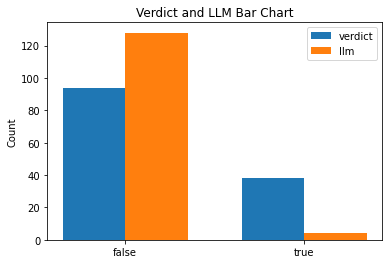

In [32]:
# Presenting 'verdict' and 'llm' of the dataTF132LLM dataframe on bar chart
verdict_data = dataTF132LLM['verdict']
llm_data = dataTF132LLM['llm']

# Count the occurrences of 'true' and 'false' in each column
verdict_counts = verdict_data.value_counts()
llm_counts = llm_data.value_counts()

# Create a bar chart with two bars for each column
fig, ax = plt.subplots()
bar_width = 0.35
index = range(len(verdict_counts))

# Plot the 'verdict' bars
verdict_bars = ax.bar(index, verdict_counts, bar_width, label='verdict')

# Plot the 'llm' bars next to the 'verdict' bars
llm_bars = ax.bar([i + bar_width for i in index], llm_counts, bar_width, label='llm')

# Set the x-axis labels
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(verdict_counts.index)

# Set the y-axis label
ax.set_ylabel('Count')

# Set the chart title
ax.set_title('Verdict and LLM Bar Chart')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [36]:
from sklearn.metrics import confusion_matrix

# Assuming 'verdict' and 'llm' are columns in the 'dataTF132LLM' dataframe
verdict = dataTF132LLM['verdict']
llm = dataTF132LLM['llm']

# Create the confusion matrix
cm = confusion_matrix(verdict, llm)

# Print the confusion matrix
print(cm)

[[92  2]
 [36  2]]


In [39]:
# Count the number of matching values in 'verdict' and 'llm' columns
matching_count = sum(dataTF132LLM['verdict'] == dataTF132LLM['llm'])

# Calculate the accuracy
accuracy = matching_count / len(dataTF132LLM)

# Print the resulting accuracy
print("Accuracy:", accuracy)

Accuracy: 0.7121212121212122
